# 2_models: Demand Modeling & Price‐Response Grid

This notebook will:
1. Load processed slot‐level data  
2. Perform slot‐level clustering  
3. Train demand‐prediction models (baseline & GBMs)  
4. Generate and save price‐response grid  


In [1]:
# 2.0 Parameters & Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit, train_test_split
import lightgbm as lgb
import catboost as cb
import optuna

# explainability
import shap



c:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# I/O paths
SLOT_PARQUET = "../data/processed/slot_level.parquet"
CLUSTER_CSV  = "../data/processed/time_slot_clusters.csv"
MODELS_DIR   = "../code/models/"
GRID_PATH    = "../data/processed/price_response_grid.csv"

## Data Loading & Validation

In [3]:
# load slot-level file
df_slot = pd.read_csv("../data/processed/slot_level.csv")

# ensure required columns are present
required = [
    "booking_rate",
    "capacity",
    "min_price",
    "max_price",
    "avg_price",
    "pct_avail",
    "lead_time",
    "day_of_week",
    "is_weekend",
    "search_date_for",
    "search_hour_for",
]
missing = [c for c in required if c not in df_slot.columns]
assert not missing, f"Missing columns: {missing}"

print("✅ slot_level.csv has all required columns.")
df_slot.head(25)


✅ slot_level.csv has all required columns.


,Venue Name,search_date_for,search_hour_for,n_searches,n_bookings,lead_time,day_of_week,is_weekend,booking_rate,avg_price,pct_avail,capacity,min_price,max_price
0,Birmingham,2024-12-11,21,1,0,NaN,0,0,0.0,14.0,1.0,4,0.0,14.0
1,Birmingham,2024-12-13,20,1,1,39.0,1,0,1.0,12.0,1.0,4,0.0,14.0
2,Birmingham,2024-12-14,13,1,0,NaN,1,0,0.0,8.0,1.0,4,0.0,14.0
3,Birmingham,2024-12-23,18,1,1,132.0,0,0,1.0,8.0,1.0,4,0.0,14.0
4,Birmingham,2025-01-18,14,1,0,NaN,0,0,0.0,10.0,1.0,4,0.0,14.0
5,Birmingham,2025-01-18,15,1,0,NaN,3,0,0.0,10.0,1.0,4,0.0,14.0
6,Birmingham,2025-02-01,15,1,0,NaN,1,0,0.0,10.0,1.0,4,0.0,14.0
7,Birmingham,2025-02-07,20,1,1,4.0,6,1,1.0,8.0,1.0,4,0.0,14.0
8,Birmingham,2025-02-08,12,1,1,-145.0,2,0,1.0,12.0,1.0,4,0.0,14.0
9,Birmingham,2025-02-15,19,1,1,-261.0,6,1,1.0,14.0,1.0,4,0.0,14.0


## Slot-Level Clustering

### Feature selection

In [4]:
# pick clustering features
X = df_slot[["booking_rate", 
             "lead_time", 
             "avg_price"]].fillna(0)


### Elbow & silhouette analysis

In [5]:
inertias, silhouettes = [], []
K = range(2,11)
for k in K:
    km = KMeans(n_clusters=k, random_state=42).fit(X)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X, km.labels_))



### Plots

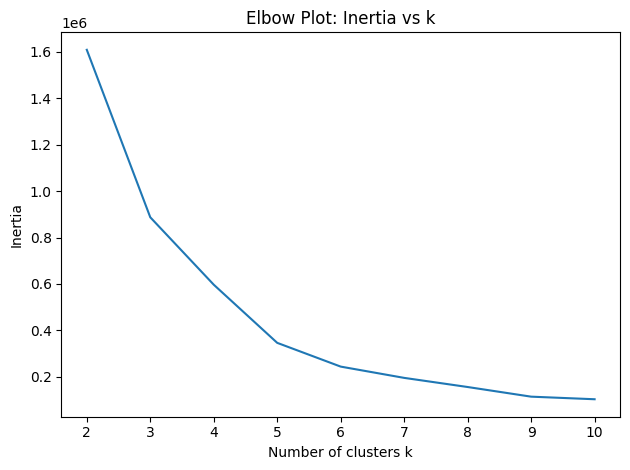

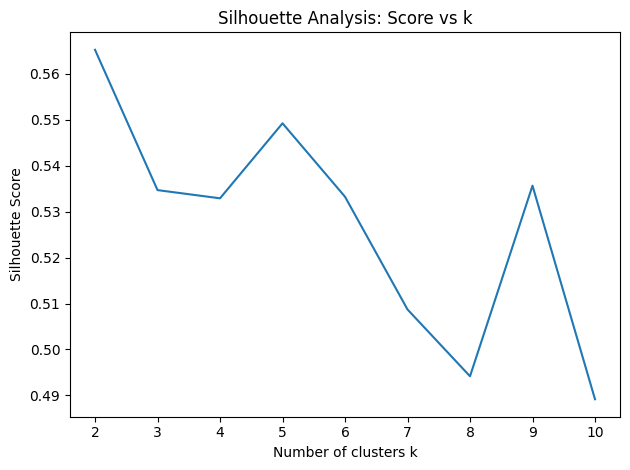

✅ Saved clusters to ../data/processed/time_slot_clusters.csv


In [6]:
# Plot Inertia (Elbow)
plt.figure()
plt.plot(list(K), inertias)
plt.xlabel("Number of clusters k")
plt.ylabel("Inertia")
plt.title("Elbow Plot: Inertia vs k")
plt.tight_layout()

# Plot Silhouette Scores
plt.figure()
plt.plot(list(K), silhouettes)
plt.xlabel("Number of clusters k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis: Score vs k")
plt.tight_layout()
plt.show()

# Per-venue auto-K clustering
clusters_list = []
label_names = ["off_peak", "mid_peak", "super_peak", "ultra_peak", "mega_peak"]

for venue, group in df_slot.groupby("Venue Name"):
    Xv = group[["booking_rate", "lead_time", "avg_price"]].fillna(0).values
    best_k = max(2, min(10, 3))  # default to 3
    best_score = -1
    for k in range(2, 11):
        km = KMeans(n_clusters=k, random_state=42).fit(Xv)
        score = silhouette_score(Xv, km.labels_)
        if score > best_score:
            best_score = score
            best_k = k
    km = KMeans(n_clusters=best_k, random_state=42).fit(Xv)
    labels = km.labels_
    # Order clusters by ascending booking_rate
    cluster_rates = [group[labels == c]["booking_rate"].mean() for c in range(best_k)]
    order = np.argsort(cluster_rates)
    slot_label_map = {}
    for rank, c in enumerate(order):
        if rank < len(label_names):
            slot_label_map[c] = label_names[rank]
        else:
            slot_label_map[c] = f"cluster_{rank}"
    df_clust = group.copy()
    df_clust["km_cluster"] = labels
    df_clust["slot_label"] = df_clust["km_cluster"].map(slot_label_map)
    clusters_list.append(
        df_clust[["Venue Name", "search_date_for", "search_hour_for", "slot_label", "km_cluster"]]
    )

time_slot_clusters = pd.concat(clusters_list, ignore_index=True)
output_path = "../data/processed/time_slot_clusters.csv"
time_slot_clusters.to_csv(output_path, index=False)

print(f"✅ Saved clusters to {output_path}")


## Per‐Venue Auto-K, Labeling & Save

In [ ]:
# 4. Weekly‐Slot Aggregation for Clustering
# df_slot should come from your slot_level parquet/csv
# with columns: Venue Name, day_of_week (0–6), search_hour_for (0–23), booking_rate

# filter to peak-booking hours
hours = list(range(12, 24))
wk = (
    df_slot
      .query("search_hour_for in @hours")
      .groupby(['Venue Name','day_of_week','search_hour_for'], as_index=False)
      .agg(mean_rate=('booking_rate','mean'))
)

# pivot to check shape: should be ~3 venues × 7 days × 12 hours = 252 rows
print(wk.shape, "rows (Venue×Day×Hour)")

wk.head()


(96, 4) rows (Venue×Day×Hour)


,Venue Name,day_of_week,search_hour_for,mean_rate
0,Birmingham,0,14,0.0
1,Birmingham,0,18,1.0
2,Birmingham,0,19,1.0
3,Birmingham,0,21,0.0
4,Birmingham,1,13,0.0


c:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
C:\Users\marti\AppData\Local\Temp\ipykernel_21436\2726542880.py:41: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.ti

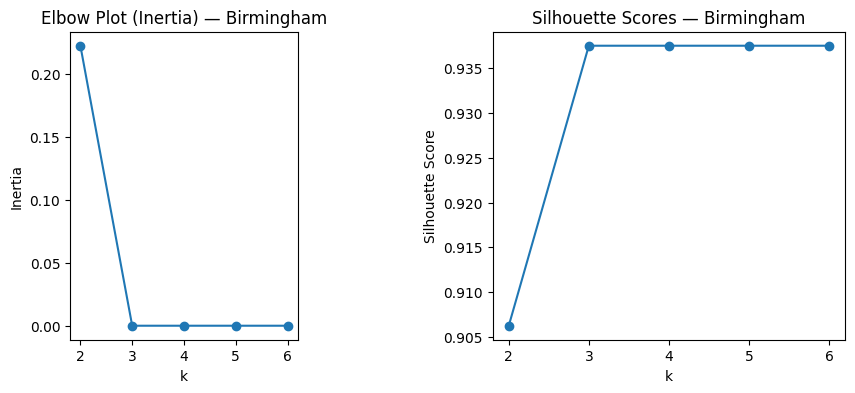

C:\Users\marti\AppData\Local\Temp\ipykernel_21436\2726542880.py:41: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


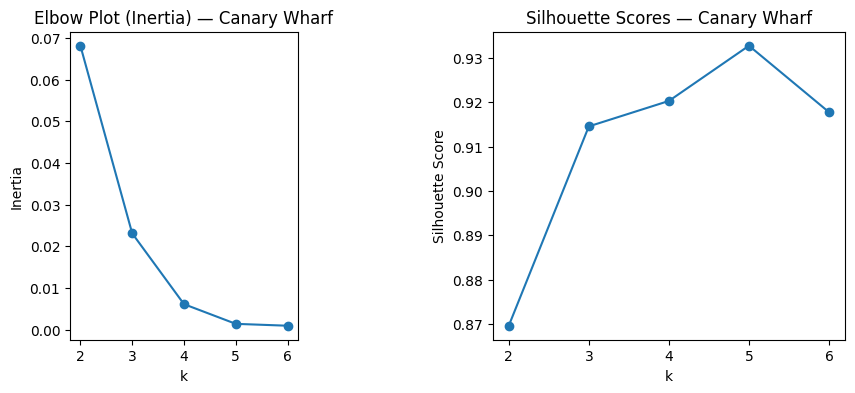

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Reload slot-level data and re-aggregate weekly slots
df_slot = pd.read_parquet("../data/processed/slot_level.parquet")

# Build weekly-slot agg for hours 12–23
wk = (
    df_slot
      .query("search_hour_for >= 12 and search_hour_for <= 23")
      .groupby(['Venue Name','day_of_week','search_hour_for'], as_index=False)
      .agg(mean_rate=('booking_rate','mean'))
)

# Per-venue elbow & silhouette plots for k=2..6
for venue in wk['Venue Name'].unique():
    sub = wk[wk['Venue Name'] == venue]
    X = sub[['mean_rate']].values
    
    Ks = range(2, 7)
    inertias = []
    silhouettes = []
    for k in Ks:
        km = KMeans(n_clusters=k, random_state=42).fit(X)
        inertias.append(km.inertia_)
        silhouettes.append(silhouette_score(X, km.labels_))
    
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(list(Ks), inertias, marker='o')
    plt.title(f'Elbow Plot (Inertia) — {venue}')
    plt.xlabel('k'); plt.ylabel('Inertia')
    
    plt.subplot(1,2,2)
    plt.plot(list(Ks), silhouettes, marker='o')
    plt.title(f'Silhouette Scores — {venue}')
    plt.xlabel('k'); plt.ylabel('Silhouette Score')
    
    plt.tight_layout()
    plt.show()



In [9]:
# Per-Venue Auto-K, Label Semantics & Save

clusters_list = []

for venue, group in df_slot.groupby("Venue Name"):
    # features for this venue
    Xv = group[["booking_rate", "lead_time", "avg_price"]].fillna(0).values

    # find best k by silhouette
    best_k, best_score = 2, -1
    for k in range(2, 11):
        km = KMeans(n_clusters=k, random_state=42).fit(Xv)
        score = silhouette_score(Xv, km.labels_)
        if score > best_score:
            best_score, best_k = score, k

    # fit final
    km   = KMeans(n_clusters=best_k, random_state=42).fit(Xv)
    labs = km.labels_

    # order clusters by ascending booking_rate
    rates = [group.iloc[labs == c]["booking_rate"].mean() for c in range(best_k)]
    order = np.argsort(rates)
    # generate labels: use generic names if not exactly 3 clusters
    names = [f"cluster_{i+1}" for i in range(best_k)]
    if best_k == 3:
        names = ["off_peak","mid_peak","super_peak"]
    slot_label_map = {orig: names[idx] for idx, orig in enumerate(order)}

    dfc = group.copy()
    dfc["km_cluster"] = labs
    dfc["slot_label"] = dfc["km_cluster"].map(slot_label_map)
    clusters_list.append(
        dfc[["Venue Name","search_date_for","search_hour_for","slot_label","km_cluster"]]
    )

time_slot_clusters = pd.concat(clusters_list, ignore_index=True)

# save
time_slot_clusters.to_csv(CLUSTER_CSV, index=False)
print(f"✅ Wrote clusters to {CLUSTER_CSV}")


✅ Wrote clusters to ../data/processed/time_slot_clusters.csv
